In [1]:
import os
import json
import hashlib
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import tensor
from datasets import Dataset, DatasetDict, concatenate_datasets, Audio, ClassLabel, Features, Value, Array2D
from transformers import ASTFeatureExtractor

In [2]:
music_lib: dict[str, list[str]] = {}
def add_songs(dir: str, skip_dirs: list[str] = [], genre: str = ""):
    for dirent in os.listdir(dir): 
        path = os.path.join(dir, dirent)
        if os.path.isdir(path) and dirent not in skip_dirs:
            add_songs(path, genre=genre if genre else dirent)
        elif os.path.isfile(path) and path.endswith(".mp3"):
            if genre not in music_lib:
                music_lib[genre] = []
            music_lib[genre].append(path)

add_songs("D:\\Music", ["$RECYCLE.BIN", "downloads", "Eigenes", "Hörbücher", "Mixes", "System Volume Information"])
for genre, songs in list(music_lib.items()):
    if len(songs) < 6: # at leat one in each dataset 
        del music_lib[genre]
    else:
        print(f"{genre}: {len(songs)} songs")

Bad: 303 songs
Bassy: 24 songs
Big Room: 57 songs
Bounce: 155 songs
Chill: 7 songs
Chill Beat: 22 songs
Chillstep: 31 songs
Classic: 82 songs
Country: 90 songs
Dance Pop: 22 songs
Deep House: 37 songs
Drum and Bass: 47 songs
Dubstep: 35 songs
EDM: 52 songs
Electro: 186 songs
Electro House: 112 songs
Emotional: 23 songs
Epic: 11 songs
Folk: 6 songs
Frenchcore: 65 songs
Glitch Hop: 31 songs
God: 20 songs
Groove: 101 songs
Hands Up: 1373 songs
Hardcore: 156 songs
Hardstyle: 222 songs
Harp: 6 songs
Hip-Hop: 30 songs
Historic: 17 songs
Latino: 40 songs
Lo-Fi: 11 songs
Lounge: 105 songs
Malle: 90 songs
Minimal: 38 songs
Motivation: 114 songs
Oldschool Techno: 388 songs
Orchestra Pop: 23 songs
Orchestral Electro: 30 songs
Psy: 76 songs
Rap: 82 songs
Rock: 174 songs
Slow: 17 songs
Techno: 39 songs
Tekk: 28 songs
Weihnachten: 21 songs


In [3]:
genres = list(music_lib.keys())
filepaths: list[str] = []
labels: list[int] = []
for genre_idx, songs in enumerate(music_lib.values()):
    for filepath in songs:
        filepaths.append(filepath)
        labels.append(genre_idx)

In [4]:
with open("../dataset/genres.json", "w+", encoding="utf-8") as f:
    json.dump(genres, f, ensure_ascii=False)

In [5]:
pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)

model_input_name = feature_extractor.model_input_names[0]
labels_name = "labels"
paths_name = "paths"

In [6]:
def hash_dict(d):
    dict_tuple = tuple(sorted(d.items()))
    return hashlib.sha256(repr(dict_tuple).encode()).hexdigest()[:48]

music_lib_hash = hash_dict(music_lib)

In [7]:
features = Features({
    model_input_name: Audio(sampling_rate=feature_extractor.sampling_rate),
    labels_name: ClassLabel(names=genres)
})

tmp_features = Features({
    model_input_name: Value("string"),
    labels_name: ClassLabel(names=genres)
})

dataset = Dataset.from_dict({
    model_input_name: filepaths,
    labels_name: labels,
}, features=tmp_features).train_test_split(
    test_size=0.3,
    shuffle=True,
    stratify_by_column=labels_name,
    load_from_cache_file=True,
    train_indices_cache_file_name="../cache/train_indices",
    test_indices_cache_file_name="../cache/validate_test_indices",
    train_new_fingerprint=f"train_{music_lib_hash}",
    test_new_fingerprint=f"validate_test_{music_lib_hash}"
)

validation_dataset = dataset["test"].train_test_split(
    test_size=2/3,
    shuffle=True,
    stratify_by_column=labels_name,
    load_from_cache_file=True,
    train_indices_cache_file_name="../cache/validate_indices",
    test_indices_cache_file_name="../cache/test_indices",
    train_new_fingerprint=f"validate_{music_lib_hash}",
    test_new_fingerprint=f"test_{music_lib_hash}"
)

dataset["validate"] = validation_dataset["train"]
dataset["test"] = validation_dataset["test"]

dataset = dataset.cast(features)
dataset

Casting the dataset:   0%|          | 0/3219 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/920 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/460 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 3219
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 920
    })
    validate: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 460
    })
})

In [8]:
sample_len_sec = 10.24
samples_per_song = 6
def preprocess_song(song):
    audio = song[model_input_name]
    sampling_rate = audio["sampling_rate"]
    wav = audio["array"]
    song_spetrograms = []
    song_labels = []
    song_paths = []
    for start_sample in range(0, len(wav), len(wav) // samples_per_song):
        end_sample = start_sample + round(sample_len_sec * sampling_rate)
        if end_sample >= len(wav):
            break
        input_wav = wav[start_sample:end_sample]
        song_spetrograms.append(feature_extractor(input_wav, sampling_rate=sampling_rate, return_tensors="pt")[model_input_name][0])
        song_labels.append(song[labels_name])
        song_paths.append(audio["path"])
    
    return song_spetrograms, song_labels, song_paths

In [9]:
def visualize_spectrum(specs, size=(10,6), cols=1, rows=1):
    plt.figure(figsize=size)
    for idx, spec in enumerate(specs):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(spec.T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label="Amplitude")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bins")
        plt.tight_layout()
    plt.tight_layout()
    plt.show()

D:\Music\Drum and Bass\Inukshuk - Happy Accidents.mp3


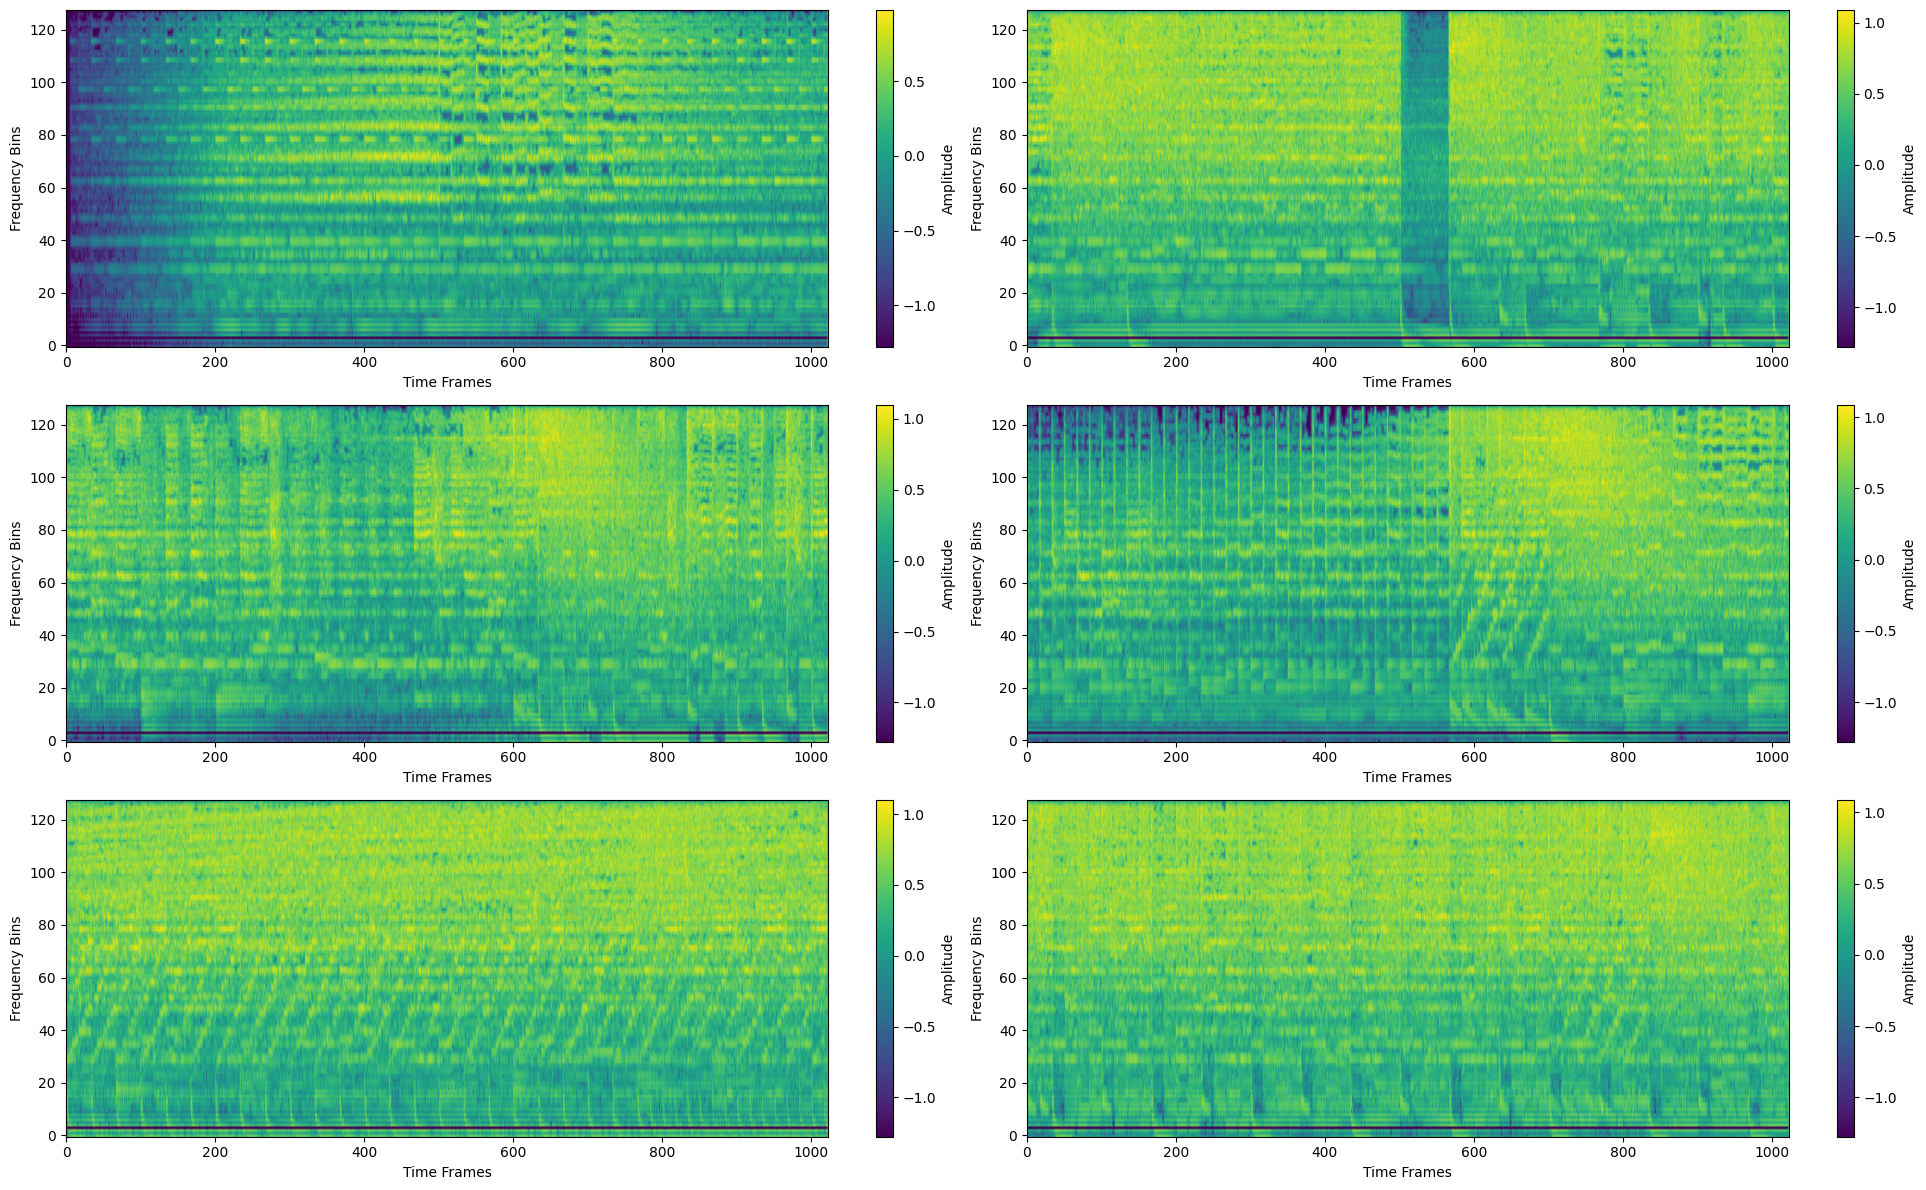

In [10]:
specs, labels, paths = preprocess_song(dataset["train"][0])
print(paths[0])
visualize_spectrum(specs, size=(20, 12),cols=2, rows=3)

In [11]:
spectrogram_features = Features({
    model_input_name: Array2D(shape=(feature_extractor.max_length, feature_extractor.num_mel_bins), dtype="float32"),
    labels_name: ClassLabel(names=genres),
    paths_name: Value(dtype="string")
})

for split, sub_dataset in dataset.items():
    batch_size = 2_000
    batch_spectrograms = []
    batch_labels = []
    batch_paths = []
    def save_batch(idx: int):
        batch_dict = {model_input_name: batch_spectrograms, labels_name: batch_labels, paths_name: batch_paths}
        partial_dataset = Dataset.from_dict(batch_dict, features=spectrogram_features)
        partial_dataset.save_to_disk(f"../spectrums/{split}_batch_{idx}")

    idx = 0
    for song in tqdm(sub_dataset, desc=f"Preparing {split} spectrums", total=len(sub_dataset)):
        song_spectrograms, song_labels, song_paths = preprocess_song(song)
        batch_spectrograms = [*batch_spectrograms, *song_spectrograms]
        batch_labels = [*batch_labels, *song_labels]
        batch_paths = [*batch_paths, *song_paths]
        if len(batch_spectrograms) >= batch_size:
            save_batch(idx)
            batch_spectrograms = []
            batch_labels = []
            batch_paths = []
            idx += 1
    save_batch(idx)

Preparing train spectrums:   0%|          | 0/3219 [00:00<?, ?it/s]

Preparing train spectrums:  10%|█         | 333/3219 [05:16<40:24,  1.19it/s]  

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  21%|██        | 667/3219 [10:52<40:52,  1.04it/s]  

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  31%|███       | 1001/3219 [16:23<33:19,  1.11it/s] 

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  41%|████▏     | 1335/3219 [22:00<34:14,  1.09s/it]  

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  52%|█████▏    | 1669/3219 [27:09<26:24,  1.02s/it]  

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  62%|██████▏   | 2003/3219 [32:31<21:44,  1.07s/it]  

Saving the dataset (0/3 shards):   0%|          | 0/2003 [00:00<?, ? examples/s]

Preparing train spectrums:  73%|███████▎  | 2337/3219 [38:14<15:09,  1.03s/it]  

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  83%|████████▎ | 2671/3219 [44:28<11:05,  1.21s/it]  

Saving the dataset (0/3 shards):   0%|          | 0/2003 [00:00<?, ? examples/s]

Preparing train spectrums:  93%|█████████▎| 3005/3219 [50:01<03:03,  1.17it/s]  

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums: 100%|██████████| 3219/3219 [53:34<00:00,  1.00it/s]


Saving the dataset (0/2 shards):   0%|          | 0/1278 [00:00<?, ? examples/s]

Preparing test spectrums:  36%|███▌      | 333/920 [04:51<07:33,  1.30it/s]

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing test spectrums:  72%|███████▎  | 667/920 [10:06<03:08,  1.34it/s]

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing test spectrums: 100%|██████████| 920/920 [14:26<00:00,  1.06it/s]


Saving the dataset (0/2 shards):   0%|          | 0/1511 [00:00<?, ? examples/s]

Preparing validate spectrums:  72%|███████▏  | 333/460 [06:14<01:52,  1.13it/s]

Saving the dataset (0/3 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing validate spectrums: 100%|██████████| 460/460 [08:53<00:00,  1.16s/it]


Saving the dataset (0/1 shards):   0%|          | 0/756 [00:00<?, ? examples/s]

In [12]:
batch_paths = [f"../spectrums/{batch_dir}" for batch_dir in os.listdir("../spectrums")]

train_batches = [Dataset.load_from_disk(path) for path in batch_paths if "train" in path]
validate_batches = [Dataset.load_from_disk(path) for path in batch_paths if "validate" in path]
test_batches = [Dataset.load_from_disk(path) for path in batch_paths if "test" in path]

train_dataset = concatenate_datasets(train_batches)
validate_dataset = concatenate_datasets(validate_batches)
test_dataset = concatenate_datasets(test_batches)

preprocessed_dataset = DatasetDict({
    "train": train_dataset,
    "validate": validate_dataset,
    "test": test_dataset
})

In [13]:
preprocessed_dataset.save_to_disk("../dataset/music_lib")

Saving the dataset (0/21 shards):   0%|          | 0/19312 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/2760 [00:00<?, ? examples/s]

Saving the dataset (0/6 shards):   0%|          | 0/5519 [00:00<?, ? examples/s]

In [14]:
preprocessed_dataset = DatasetDict.load_from_disk("../dataset/music_lib")
preprocessed_dataset

Loading dataset from disk:   0%|          | 0/21 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 19312
    })
    validate: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 2760
    })
    test: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 5519
    })
})

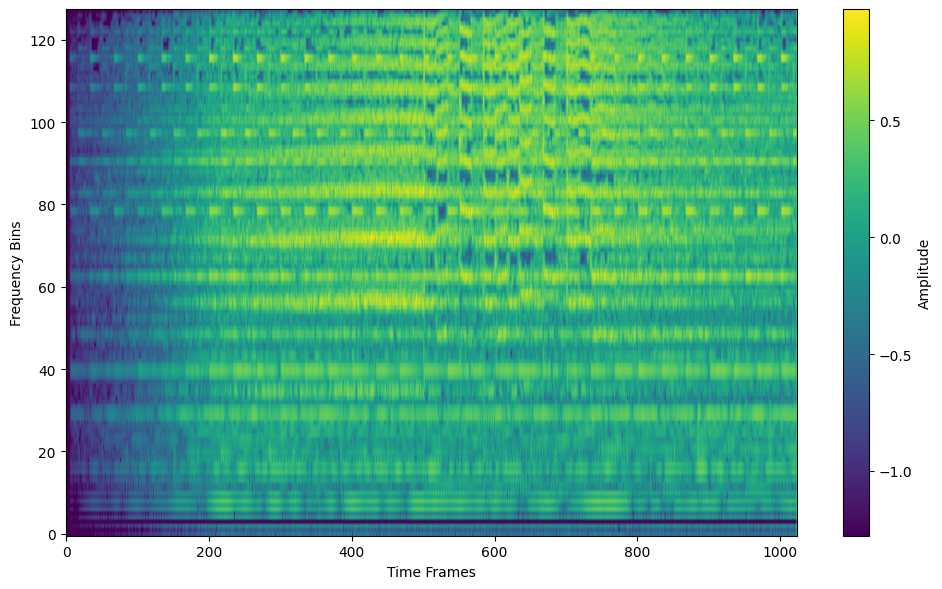

In [15]:
visualize_spectrum(tensor([preprocessed_dataset["train"][0]["input_values"]]))